# Movilizate Salud

## ---------Inicializacion (One Time Run Only)---------

In [139]:
#Importando librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
import pybingmaps
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import timeit
from sklearn.model_selection import train_test_split
from sklearn import linear_model

#Key API Maps
bing = pybingmaps.Bing('AizoCiuRwxjT9SjxftwCItVoRXI2v0V3UnLTKSebigC5GUW5NklrIZpL5jRANFuJ')

#Porcentajes de Preferencia, dados por el usuario. En esta etapa fueron definidos por el equipo
pref_Tiempo = 0.4
pref_Distancia = 0.15
pref_Consultorio = 0.15
pref_Medicos = 0.3

In [140]:
#Importando los datos y convirtiendolo en un dataframe
df_Hospitals = pd.read_excel("./Master_Dataset_AI_Saturday.xlsx")

In [141]:
# Juntando las coordenadas de los hospitales en un solo dataframe que es utilizado por el algoritmo de Nearest Neighbors
df_LatitudHospitals = pd.DataFrame(df_Hospitals['LATITUD'])
df_LongitudHospitals = pd.DataFrame(df_Hospitals['LONGITUD'])
df_coordenadasHospitals = df_LatitudHospitals.join(df_LongitudHospitals)

Ev_hospitales = df_Hospitals

# Percentrank(Evaluacion) de los parametros Total de Consultorios y Medicos Generales (Variables Estaticas)

Ev_hospitales['Ev_Consultorios'] = Ev_hospitales.reset_index() \
                                [['TOTAL DE CONSULTORIOS']] \
                                .apply(lambda x: (x.rank(method='dense') - 1) / (x.nunique() - 1) ) \
                                .values

Ev_hospitales['Ev_Medicos'] = Ev_hospitales.reset_index() \
                            [['TOTAL MEDICOS GENERALES Y ESPECIALISTAS']] \
                            .apply(lambda x: (x.rank(method='dense') - 1) / (x.nunique() - 1) ) \
                            .values

# Se añade Calificacion al dataframe de evaluación la cual suma de estos dos parametros multiplicado por
#su factor de preferencia
Ev_hospitales["Calificacion"] =( (Ev_hospitales['Ev_Consultorios']* pref_Consultorio)
                                                +(Ev_hospitales['Ev_Medicos']* pref_Medicos))

## ---------Training Inicial (One Time Run Only)---------

#### Nearest Neighbors

In [142]:
#DOCUMENTACION K NEAREST NEIGHBORS
#https://scikit-learn.org/stable/modules/neighbors.html
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

#Solamente se seleccionaran los 10 neighbors mas cercanos
nbrs = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(df_coordenadasHospitals)

#### Bayesian Ridge Regression

In [143]:
#DOCUMENTACION BAYESIAN RIDGE REGRESSION
#https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression

In [144]:
X = Ev_hospitales[['TOTAL DE CONSULTORIOS','TOTAL MEDICOS GENERALES Y ESPECIALISTAS']]
y = Ev_hospitales['Calificacion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=417)

In [145]:
regr = linear_model.BayesianRidge()
reg = regr.fit(X_train, y_train)
y_pred = reg.predict(X_test)

## ------------Final Method (This will be excuted everytime you wanna get the info)--------------

In [146]:
def funcionEvaluacion(df_my_location):
    #Entrenamiento no supervisado del algoritmo K Nearest Neighbor
    distances, indices = nbrs.kneighbors(df_my_location)
    df_Out = pd.DataFrame(indices)
    df_Out = df_Out.T
    df_Out = df_Out.rename({0: "Indice"}, axis='columns')
    
    # Se empieza crear el dataframe final el cual va a contener toda la informacion de salida
    # La API añade los tiempos de traslado y distancia al dataframe
    
    for i in df_Out.index:
        indice = df_Out.iat[i,0]
        df_Out.at[i, 'Latitud'] = df_Hospitals.iat[indice,4]  
        df_Out.at[i, 'Longuitud'] = df_Hospitals.iat[indice,5]  
        df_Out.at[i, 'NOMBRE DE LA UNIDAD'] = df_Hospitals.iat[indice,8]   
        df_Out.at[i, 'TOTAL DE CONSULTORIOS'] = df_Hospitals.iat[indice,9]
        df_Out.at[i, 'TOTAL MEDICOS GENERALES Y ESPECIALISTAS'] = df_Hospitals.iat[indice,12]   
        hospital_location = (df_Hospitals.iat[indice,4], df_Hospitals.iat[indice,5])
        df_Out.at[i, 'Tiempo_Estimado(seg)'] = bing.travelTime(my_location, hospital_location )
        df_Out.at[i, 'Distancia_Estimada(km)'] = bing.travelDistance(my_location, hospital_location)
    
    #Se hace la prediccion de las calificaciones mediante el algoritmo de Bayesian Ridge Regressor       
    pred = df_Out[['TOTAL DE CONSULTORIOS','TOTAL MEDICOS GENERALES Y ESPECIALISTAS']]
    df_Out["Calificacion"] = reg.predict(pred)
    
    # Haciendo el PercentRank de las variables que no son estaticas sobre el data frame ya filtrado de los nearest neighbors
    df_Out['Ev_Tiempo'] = df_Out.reset_index() \
                        [['Tiempo_Estimado(seg)']] \
                        .apply(lambda x: (x.rank(method='dense') - 1) / (x.nunique() - 1) ) \
                        .values

    df_Out['Ev_Distancia'] = df_Out.reset_index() \
                            [['Distancia_Estimada(km)']] \
                            .apply(lambda x: (x.rank(method='dense') - 1) / (x.nunique() - 1) ) \
                            .values
    
    # Aquellos parametros que sean los menores seran los que tengan la maxima calificacion
    df_Out["Ev_Tiempo"] = (-1 * df_Out["Ev_Tiempo"])+1
    df_Out["Ev_Distancia"] = (-1 * df_Out["Ev_Distancia"])+1
    
    # Sumando todas las calificaciones y multiplicandolas por su factor de preferencia para obtener la calificacion final
    for i in df_Out.index:
        df_Out["Calificacion_Final"] =( df_Out['Ev_Tiempo'] * pref_Tiempo
                                      +df_Out['Ev_Distancia']* pref_Distancia
                                      +df_Out['Calificacion'])
        
    df_Out = df_Out.drop(['Calificacion'], axis=1)
    df_Out = df_Out.drop(['Ev_Tiempo'], axis=1)
    df_Out = df_Out.drop(['Ev_Distancia'], axis=1)

        
    #Haciendo el rankeo final con las calificaciones finales obtenidas
    df_Out["Ranking"] = df_Out['Calificacion_Final'].rank(method='dense', ascending = False)

    result = df_Out
    return result

## *Inputs

In [147]:
#Inicializacion de variables de tu posicion
my_latitude =20.677041
my_longuitud =-103.347745
my_location = (my_latitude, my_longuitud)
df_my_location = pd.DataFrame({'Latitud': [my_latitude],'Longuitud': [my_longuitud]})

In [148]:
tic=timeit.default_timer()

df_Output = funcionEvaluacion(df_my_location)

toc=timeit.default_timer()

print("Tiempo de Busqueda del Mejor Hospital:",toc-tic)

Tiempo de Busqueda del Mejor Hospital: 6.522355530999448


In [149]:
df_Output

,Indice,Latitud,Longuitud,NOMBRE DE LA UNIDAD,TOTAL DE CONSULTORIOS,TOTAL MEDICOS GENERALES Y ESPECIALISTAS,Tiempo_Estimado(seg),Distancia_Estimada(km),Calificacion_Final,Ranking
0,170,20.679007,-103.342022,UNIDAD MÓVIL DE COLPOSCOPIA,1.0,1.0,175.0,0.783,0.578557,6.0
1,37,20.690800,-103.353000,CENTRO DE SALUD GUADALAJARA 3,13.0,26.0,417.0,2.067,0.609958,4.0
2,69,20.673800,-103.333000,CENTRO DE SALUD N°1,9.0,15.0,465.0,2.286,0.465255,9.0
3,157,20.691573,-103.352040,UMF 79 GUADALAJARA,10.0,15.0,501.0,2.765,0.408871,10.0
4,139,20.660603,-103.350850,UMF 1 GUADALAJARA,26.0,51.0,320.0,1.920,0.820690,1.0
5,144,20.685355,-103.331897,UMF 3 GUADALAJARA,36.0,84.0,607.0,2.202,0.717567,2.0
6,149,20.664053,-103.334850,UMF 49 GUADALAJARA,10.0,20.0,398.0,2.600,0.561902,7.0
7,120,20.696100,-103.348000,CENTRO DENTAL INFANTIL DE ESPECIALIDADES,5.0,17.0,421.0,2.185,0.504863,8.0
8,143,20.689246,-103.364809,UMF 2 GUADALAJARA,37.0,73.0,641.0,3.073,0.580228,5.0
9,150,20.698207,-103.349474,UMF 51 GUADALAJARA,33.0,60.0,506.0,2.742,0.646455,3.0


## ------------ Esto solo es para visualizacion en el notebook, no va en la aplicacion-------------

(-103.7, -103)

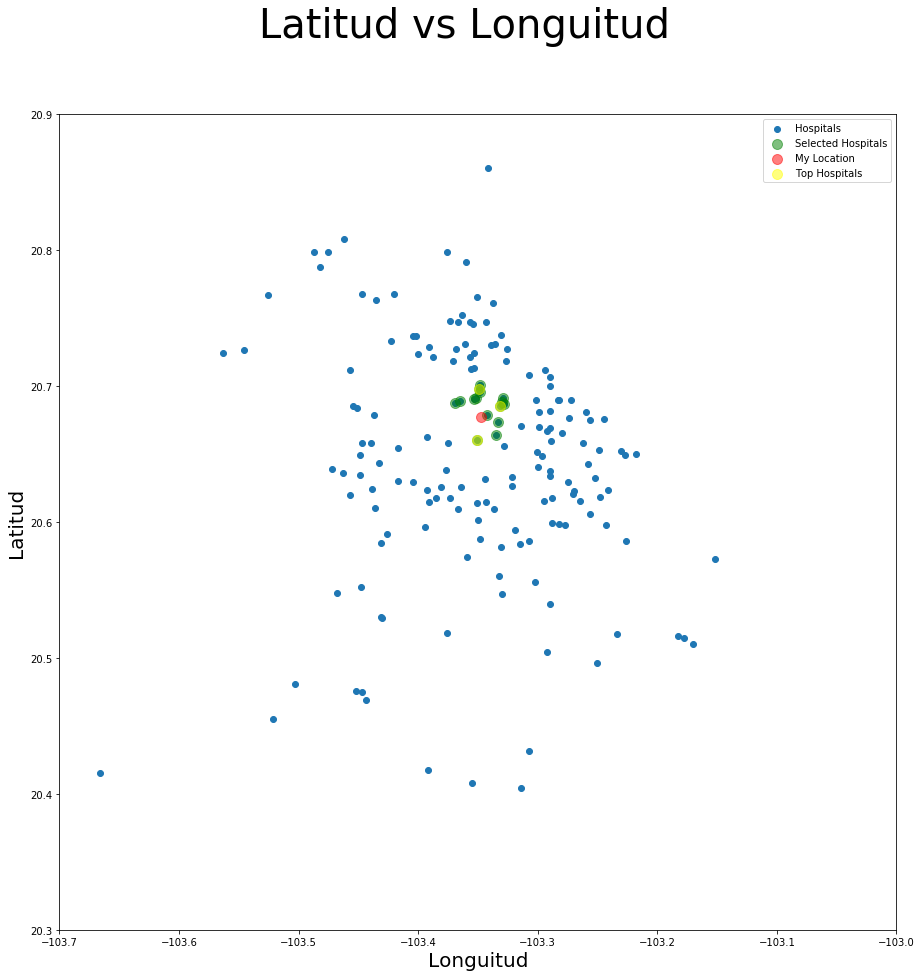

In [150]:
vissual = df_Output

df_LatitudHospitals = pd.DataFrame(vissual['Latitud'])
df_LongitudHospitals = pd.DataFrame(vissual['Longuitud'])
vissual =df_LatitudHospitals .join(df_LongitudHospitals)
array_indices = vissual.to_numpy()

Sort = df_Output.sort_values(by='Calificacion_Final', ascending=False)

Selected = {'Latitud': [0.0,0.0,0.0], 'Longuitud': [0.0,0.0,0.0]}
Selected = pd.DataFrame(Selected, columns = ['Latitud', 'Longuitud'])
for i in range(3):
    Selected.at[i, 'Latitud'] = Sort.iat[i,1]  
    Selected.at[i, 'Longuitud'] = Sort.iat[i,2] 
Top_Hospitals = Selected.to_numpy()

plt.subplots(figsize=(15, 15))
plt.scatter(df_Hospitals['LONGITUD'], df_Hospitals['LATITUD'], cmap='viridis',label='Hospitals')
plt.scatter(array_indices[:, 1], array_indices[:, 0], c='green', s=100, alpha=0.5,label='Selected Hospitals');
plt.scatter(my_longuitud, my_latitude, c='red', s=100, alpha=0.5, label='My Location');
plt.scatter(Top_Hospitals[:, 1], Top_Hospitals[:, 0], c='yellow', s=100, alpha=0.5, label='Top Hospitals');

plt.suptitle('Latitud vs Longuitud',fontsize=40)
plt.xlabel('Longuitud', fontsize=20)
plt.ylabel('Latitud', fontsize=20)
plt.legend(loc='best')

plt.ylim(20.3, 20.9)
plt.xlim(-103.7, -103)
